# Shapes of objects
Distinguishing Non Stops and M&Ms can be done with the following steps. 

First we import all of the necessary libraries in order to perform anylisis on the image. Then we crop, read, grayscale and binarise the image. 

Text(0.5, 1.0, 'Binary image')

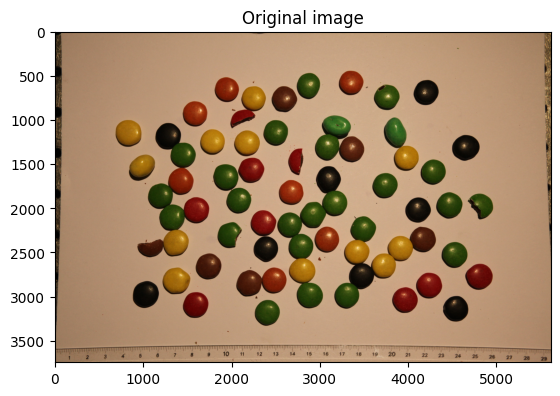

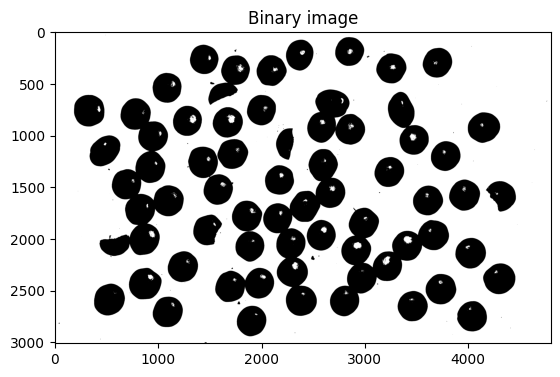

In [126]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, measure
from skimage.morphology import erosion, dilation, disk
from skimage.segmentation import watershed
from scipy import ndimage as nd
import matplotlib.patches as mpatches
from skimage.feature import peak_local_max
import pandas as pd

image = io.imread('IMG_2754_nonstop_alltogether.JPG')
plt.figure()
plt.imshow(image, 'gray')
plt.title("Original image")

image_crop = image[390:3400, 500:5300]
image_gray = image_crop.mean(axis=2)
th = 125
binary = (image_gray > th)

plt.figure()
plt.imshow(binary, 'gray')
plt.title("Binary image")

Then we invert the binary image in order to fill the holes created by the light reflection of the objects in the image. 

There might be som noise in the image like the small particles from the broken Non stops. To avoid these the process erosion can be used which is a morphological technique in order to shrink bright regions and enlarge dark regions. By enlarging the the dark regions we fill the particles in the picture.

After erosion the objects have decrease in size as they are also bright and the shape might be a little bit different than its original. To avoid the unaccuracy created it is possible to use dilation which is another morphological process, this process enlarges bright regions and shrinks dark regions.

Text(0.5, 1.0, 'Image after dilation')

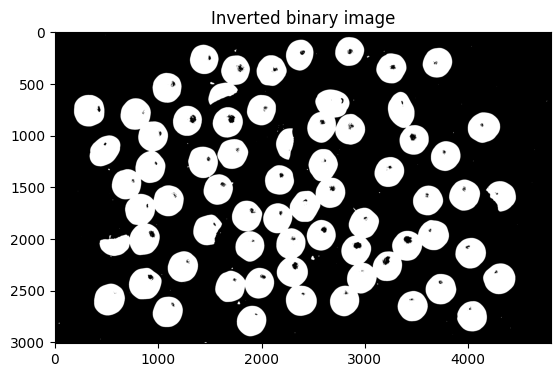

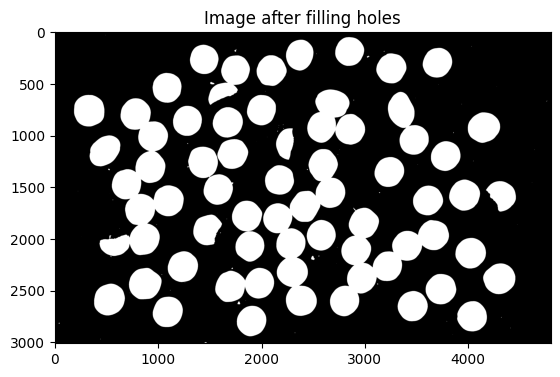

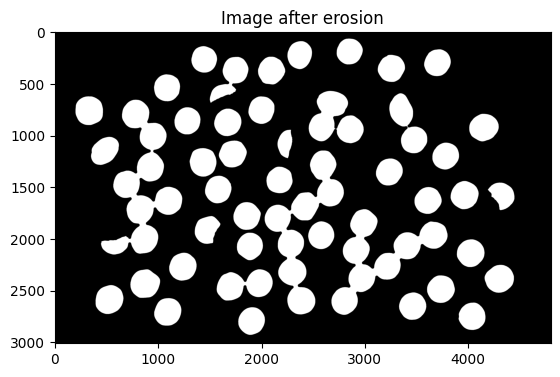

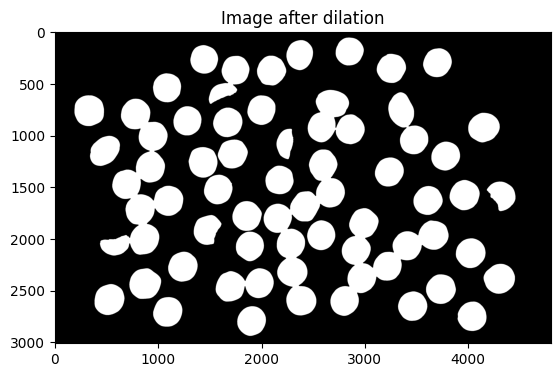

In [132]:
inv_img = np.invert(binary)
plt.figure()
plt.imshow(inv_img, 'gray')
plt.title("Inverted binary image")

fill_holes = nd.binary_fill_holes(inv_img)
plt.figure()
plt.imshow(fill_holes, 'gray')
plt.title("Image after filling holes")

img_eroded = erosion(fill_holes, disk(14))
plt.figure()
plt.imshow(img_eroded, 'gray')
plt.title("Image after erosion")

img_dil = dilation(img_eroded, disk(10))
plt.figure()
plt.imshow(img_dil, cmap='gray')
plt.title("Image after dilation")

After the dilation process some of the objects may overlap on eachother hence making it difficult to identify them individually. 

Different segmentation techniques can be used in order to seperate the objects into individual parts. For this part we use the watershed method. 

First we use the peak_local_max function which returns the coordinates of local peaks (maxima) in an image.

Then mask the image and apply the watershed technique.

The watershed transformation treats the image it operates upon like a topographic map, with the brightness of each point representing its height, and finds the lines that run along the tops of ridges.
Source:https://en.wikipedia.org/wiki/Watershed_%28image_processing%29

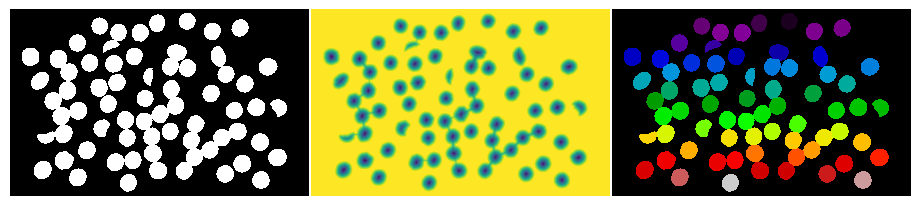

In [134]:
distance = nd.distance_transform_edt(img_dil)

# markers = nd.label(distance)[0]

coords = peak_local_max(distance, footprint=disk(15), min_distance=50)
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = nd.label(mask)
labels = watershed(-distance, markers, mask=img_dil)


plt.figure(figsize=(9, 3.5))
plt.subplot(131)
plt.imshow(img_dil, cmap='gray', interpolation='nearest')
plt.axis('off')
plt.subplot(132)
plt.imshow(-distance, interpolation='nearest')
plt.axis('off')
plt.subplot(133)
plt.imshow(labels, cmap='nipy_spectral', interpolation='nearest')
plt.axis('off')

plt.subplots_adjust(hspace=0.01, wspace=0.01, top=1, bottom=0, left=0, right=1)

Now it is possible measeure the region of the objects and get their properties. 

The Non Stops are more round than the M&Ms so a good way to to use the measured properties of the objects in the image is to calculate the roundness of the objects and set a threshold. I saw that most of the Non stops fulfilled this criteria: $roundness \geq 0.80$ where roundness is given by the following formula.

$$
roundness = \frac{4 A}{\pi Majoraxis length^2}
$$

The roundness of M&Ms and the broken Non stops where a little bit more difficult as they had in some cases had the same or even larger roundness. They differed a little bit in their circularity as the M&Ms had a little higher value. The circularity is can be found from the this formula:

$$
circularity = \frac{4A}{\pi Perimeter^2}
$$

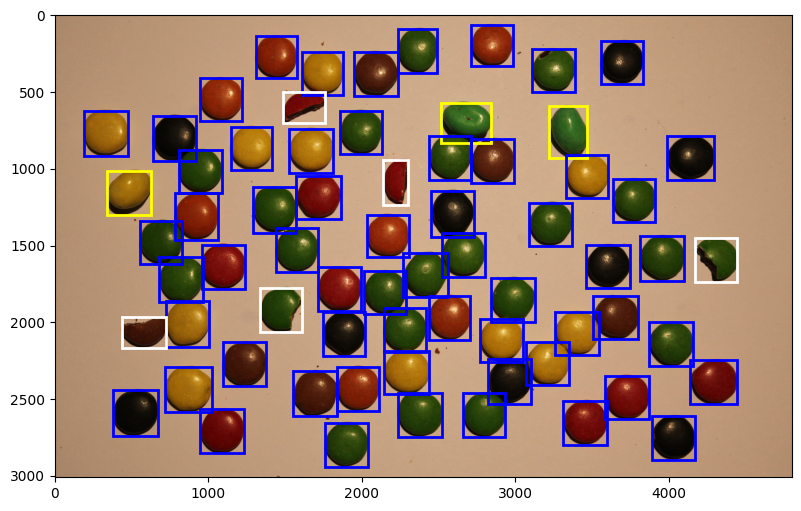

In [150]:
properties = measure.regionprops(labels)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_crop)

for ind, prop in enumerate(properties):
    
    # Calculating roundness and circularity
    roundness = (4*prop.area)/(np.pi * prop.axis_major_length * prop.axis_major_length)
    circularity = (4*prop.area)/(np.pi*prop.perimeter*prop.perimeter)
    
    # These are most likely Non stops as the their roundness is very close to 1
    if roundness >= 0.80:
        minr, minc, maxr, maxc = prop.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='blue', linewidth=2)
        ax.add_patch(rect)
        
    # This is somewhat of a very manual implementation 
    elif circularity > 0.083:
        minr, minc, maxr, maxc = prop.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='yellow', linewidth=2)
        ax.add_patch(rect)
        
    # The rest are broken Non stops
    else:
        minr, minc, maxr, maxc = prop.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr, 
                                  fill=False, edgecolor='white', linewidth=2)
        ax.add_patch(rect)